In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import tarfile
import pickle

In [2]:
DATASET_ZIP_PATH = "./data/cifar-10-python.tar.gz"
DATASET_FOLDER_PATH = "cifar-10-batches-py/data_batch_1/"

#### Load the data 

In [3]:
def load_dataset():
    """Load CIFAR-10 dataset from a compressed tar file.

    Returns:
        numpy.ndarray: Images data.
    """
    with tarfile.open(DATASET_ZIP_PATH, 'r:gz') as tar_file:
        file = tar_file.extractfile(DATASET_FOLDER_PATH)
        data = pickle.load(file, encoding='bytes')
    images = data[b'data']
    return images

def load_images():
    """Load CIFAR-10 images and convert them to grayscale.

    Returns:
        numpy.ndarray: Grayscale images.
    """
    images = load_dataset()
    num_images = len(images)
    images = images.reshape(num_images, 3, 32, 32).transpose(0, 2, 3, 1)
    grayscale_images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]
    return np.array(grayscale_images)

#### Additive noise

In [4]:
def add_noise(img, mean=0, std=30):
    """Add Gaussian noise to an image.
    
    Args:
        img (numpy.ndarray): Input image.
        mean (float): Mean of the Gaussian noise distribution.
        std (float): Standard deviation of the Gaussian noise distribution.

    Returns:
        tuple: Tuple containing original image and noisy image.
    """
    h, w = img.shape
    noise = np.random.normal(mean, std, (h, w))
    img_noisy = img + noise
    img_noisy = np.clip(img_noisy, 0, 255).astype(np.uint8)
    return img, img_noisy

#### Spatial domain filters for image denoising
1. Averaging filter
2. Gaussian filter
3. Median filter

In [5]:
def averaging_filter(img, kernel_size):
    """Apply an averaging filter to the image.

    Args:
        img (numpy.ndarray): Input image.
        kernel_size (int): Size of the square filter kernel.

    Returns:
        numpy.ndarray: Filtered image.
    """
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
    return cv2.filter2D(img, -1, kernel)

def gaussian_filter(img, kernel_size):
    """Apply a Gaussian filter to the image.

    Args:
        img (numpy.ndarray): Input image.
        kernel_size (int): Size of the Gaussian kernel.

    Returns:
        numpy.ndarray: Filtered image.
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def median_filter(img, kernel_size):
    """Apply a median filter to the image.

    Args:
        img (numpy.ndarray): Input image.
        kernel_size (int): Size of the square filter kernel.

    Returns:
        numpy.ndarray: Filtered image.
    """
    return cv2.medianBlur(img, kernel_size)


#### Frequency domain filters for image denoising
1. Low pass filter
2. Butterworth filter
3. Gaussian filter

In [6]:
def low_pass_filter(img, d0):
    """Apply a low-pass filter to the image in the frequency domain.

    Args:
        img (numpy.ndarray): Input image.
        d0 (float): Cut-off frequency.

    Returns:
        tuple: Tuple containing filtered image and shifted Fourier transform.
    """
    h, w = img.shape
    img_fft = np.fft.fft2(img)
    img_fft_shift = np.fft.fftshift(img_fft)

    y, x = np.ogrid[-h//2:h-h//2, -w//2:w-w//2]
    mask = x*x + y*y <= d0*d0

    img_fft_shift = img_fft_shift * mask

    img_fft = np.fft.ifftshift(img_fft_shift)
    img_filtered = np.fft.ifft2(img_fft).real
    return img_filtered, img_fft_shift

def low_pass_butterworth_filter(img, d0, n = 2):
    """Apply a low-pass Butterworth filter to the image in the frequency domain.

    Args:
        img (numpy.ndarray): Input image.
        d0 (float): Cut-off frequency.
        n (int): Order of the filter.

    Returns:
        tuple: Tuple containing filtered image and shifted Fourier transform.
    """
    h, w = img.shape
    img_fft = np.fft.fft2(img)
    img_fft_shift = np.fft.fftshift(img_fft)

    y, x = np.ogrid[-h//2:h-h//2, -w//2:w-w//2]
    d = np.sqrt(x*x + y*y)

    butterworth = 1 / (1 + (d / d0)**(2*n))

    img_fft_shift = img_fft_shift * butterworth

    img_fft = np.fft.ifftshift(img_fft_shift)
    img_filtered = np.fft.ifft2(img_fft).real
    return img_filtered, img_fft_shift


def low_pass_gaussian_filter(img, d0):
    """Apply a low-pass Gaussian filter to the image in the frequency domain.

    Args:
        img (numpy.ndarray): Input image.
        d0 (float): Cut-off frequency.

    Returns:
        tuple: Tuple containing filtered image and shifted Fourier transform.
    """
    h, w = img.shape
    img_fft = np.fft.fft2(img)
    img_fft_shift = np.fft.fftshift(img_fft)

    y, x = np.ogrid[-h//2:h-h//2, -w//2:w-w//2]
    d = np.sqrt(x*x + y*y)

    gaussian = np.exp(-(d**2) / (2 * d0**2))

    img_fft_shift = img_fft_shift * gaussian

    img_fft = np.fft.ifftshift(img_fft_shift)
    img_filtered = np.fft.ifft2(img_fft).real
    return img_filtered, img_fft_shift


#### FFT, IFFT

In [7]:
import numpy as np

def fft1d(x):
    """
    Perform 1D Fast Fourier Transform (FFT) recursively.

    Args:
        x (numpy.ndarray): Input signal.

    Returns:
        numpy.ndarray: FFT of the input signal.
    """
    N = len(x)
    if N <= 1:
        return x
    else:
        even = fft1d(x[0::2])
        odd = fft1d(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([even + factor[:N//2] * odd,
                               even + factor[N//2:] * odd])

def ifft1d(X):
    """
    Perform 1D Inverse Fast Fourier Transform (IFFT) recursively.

    Args:
        X (numpy.ndarray): Input frequency domain signal.

    Returns:
        numpy.ndarray: IFFT of the input frequency domain signal.
    """
    N = len(X)
    if N <= 1:
        return X
    else:
        even = ifft1d(X[0::2])
        odd = ifft1d(X[1::2])
        factor = np.exp(2j * np.pi * np.arange(N) / N)
        return np.concatenate([even + factor[:N//2] * odd,
                               even + factor[N//2:] * odd]) / 2

def fft2d(img):
    """
    Perform 2D Fast Fourier Transform (FFT) on an image.

    Args:
        img (numpy.ndarray): Input image.

    Returns:
        numpy.ndarray: 2D FFT of the input image.
    """
    M, N = img.shape
    if M % 2 != 0 or N % 2 != 0:
        raise ValueError("Image dimensions must be even for FFT.")
    
    # One-dimensional FFT along rows
    F = np.zeros((M, N), dtype=np.complex128)
    for i in range(M):
        F[i, :] = fft1d(img[i])

    # One-dimensional FFT along columns
    for j in range(N):
        F[:, j] = fft1d(F[:, j])

    return F

def ifft2d(F):
    """
    Perform 2D Inverse Fast Fourier Transform (IFFT) on a frequency domain image.

    Args:
        F (numpy.ndarray): Input frequency domain image.

    Returns:
        numpy.ndarray: 2D IFFT of the input frequency domain image.
    """
    M, N = F.shape
    
    # One-dimensional IFFT along rows
    f = np.zeros((M, N), dtype=np.complex128)
    for i in range(M):
        f[i, :] = ifft1d(F[i])

    # One-dimensional IFFT along columns
    for j in range(N):
        f[:, j] = ifft1d(f[:, j])

    return f


#### Metrics

In [8]:
PIXEL_MAX = 255.0
PIXEL_MIN = 0.0

def mse(img1, img2):
    """Compute the Mean Squared Error between two images."""
    return np.mean( (img1 - img2) ** 2 )

def psnr(img1, img2):
    """Compute the Peak Signal to Noise Ratio between two images."""
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))



#### Add. fucntions

In [9]:
def plot_images(img1, img2):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(img1, cmap='gray')
    axs[1].imshow(img2, cmap='gray')
    plt.show()

## Image denoising

#### Add noise to images

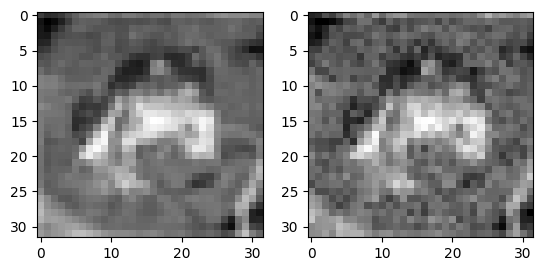

In [10]:
images = load_images()
images_noisy = []

for i in range((len(images))):
    img, img_noisy = add_noise(images[i], 0, 15)
    images_noisy.append(img_noisy)

for i in range(1):
    plot_images(images[i], images_noisy[i])

In [11]:
kernel_size_mean = []

def evaluate_filter(filter_func, filter_name, img_noisy, img, max_value=10, step=2):
    mse_values = {}
    psnr_values = {}

    for i in range(1, max_value, step):
        img_filtered = filter_func(img_noisy, i)

        mse_value = mse(img, img_filtered)
        psnr_value = psnr(img, img_filtered)

        mse_values[i] = mse_value
        psnr_values[i] = psnr_value

    min_mse = min(mse_values.values())
    kernel_size = min(mse_values, key=mse_values.get)
    print(f"Min MSE: {min_mse} at kernel size: {kernel_size}")

    kernel_size_mean.append(kernel_size)


for i in range(len(images)):
    evaluate_filter(averaging_filter, "Low Pass", images_noisy[i], images[i])
    evaluate_filter(median_filter, "Low Pass Butterworth", images_noisy[i], images[i])
    evaluate_filter(gaussian_filter, "Low Pass Gaussian", images_noisy[i], images[i])

np.mean(kernel_size_mean)


Min MSE: 71.4619140625 at kernel size: 3
Min MSE: 73.5185546875 at kernel size: 3
Min MSE: 65.9482421875 at kernel size: 3
Min MSE: 74.9365234375 at kernel size: 1
Min MSE: 74.9365234375 at kernel size: 1
Min MSE: 74.9365234375 at kernel size: 1
Min MSE: 60.5517578125 at kernel size: 3
Min MSE: 50.515625 at kernel size: 3
Min MSE: 58.5556640625 at kernel size: 3
Min MSE: 59.4140625 at kernel size: 3
Min MSE: 62.5556640625 at kernel size: 3
Min MSE: 58.533203125 at kernel size: 3
Min MSE: 68.3671875 at kernel size: 3
Min MSE: 63.30859375 at kernel size: 3
Min MSE: 59.373046875 at kernel size: 3
Min MSE: 74.6494140625 at kernel size: 3
Min MSE: 70.8037109375 at kernel size: 3
Min MSE: 69.1162109375 at kernel size: 3
Min MSE: 69.1865234375 at kernel size: 3
Min MSE: 66.80859375 at kernel size: 3
Min MSE: 64.4033203125 at kernel size: 3
Min MSE: 77.0595703125 at kernel size: 3
Min MSE: 73.4091796875 at kernel size: 3
Min MSE: 71.029296875 at kernel size: 3
Min MSE: 60.611328125 at kernel s

3.1224

In [12]:
cut_off_freq = []

def evaluate_low_pass_filter(filter_func, filter_name, img_noisy, img, max_value=20, step=2):
    mse_values = {}
    psnr_values = {}

    for i in range(1, max_value, step):
        img_filtered, img_fft_shift = filter_func(img_noisy, i)

        mse_value = mse(img, img_filtered)
        psnr_value = psnr(img, img_filtered)

        mse_values[i] = mse_value
        psnr_values[i] = psnr_value

    min_mse = min(mse_values.values())
    min_mse_freq = min(mse_values, key=mse_values.get)
    print(f"Min MSE: {min_mse} at cut-off frequency: {min_mse_freq}")

    cut_off_freq.append(min_mse_freq)

for i in range(len(images)):
    evaluate_low_pass_filter(low_pass_filter, "Low Pass", images_noisy[i], images[i])
    evaluate_low_pass_filter(low_pass_butterworth_filter, "Low Pass Butterworth", images_noisy[i], images[i])
    evaluate_low_pass_filter(low_pass_gaussian_filter, "Low Pass Gaussian", images_noisy[i], images[i])

np.mean(cut_off_freq)

Min MSE: 139.33098373189597 at cut-off frequency: 13
Min MSE: 108.11577903734519 at cut-off frequency: 13
Min MSE: 110.95154704631291 at cut-off frequency: 11
Min MSE: 184.5037988534542 at cut-off frequency: 13
Min MSE: 146.88497641459617 at cut-off frequency: 15
Min MSE: 158.09827206506606 at cut-off frequency: 15
Min MSE: 143.14405934985493 at cut-off frequency: 15
Min MSE: 113.89119676553679 at cut-off frequency: 15
Min MSE: 121.30499309584283 at cut-off frequency: 13
Min MSE: 125.66331003186427 at cut-off frequency: 11
Min MSE: 96.20945988200546 at cut-off frequency: 11
Min MSE: 95.1170660829006 at cut-off frequency: 9
Min MSE: 150.12462028349555 at cut-off frequency: 13
Min MSE: 116.07321445696047 at cut-off frequency: 13
Min MSE: 125.7938247391158 at cut-off frequency: 13
Min MSE: 163.35164781402003 at cut-off frequency: 13
Min MSE: 122.30846206578795 at cut-off frequency: 13
Min MSE: 127.37110023648056 at cut-off frequency: 11
Min MSE: 165.43488147423201 at cut-off frequency: 13

Min MSE: 125.76959105854948 at cut-off frequency: 13
Min MSE: 137.79510857260706 at cut-off frequency: 13
Min MSE: 143.4471315885172 at cut-off frequency: 13
Min MSE: 103.61723927264693 at cut-off frequency: 11
Min MSE: 109.87655392164667 at cut-off frequency: 11
Min MSE: 147.67405042689393 at cut-off frequency: 13
Min MSE: 114.23735474242557 at cut-off frequency: 13
Min MSE: 120.22676897288441 at cut-off frequency: 11
Min MSE: 86.18443674004664 at cut-off frequency: 7
Min MSE: 67.77351090883506 at cut-off frequency: 7
Min MSE: 64.57902533245343 at cut-off frequency: 7
Min MSE: 165.07326437346794 at cut-off frequency: 13
Min MSE: 118.15899661916386 at cut-off frequency: 13
Min MSE: 126.09475347250013 at cut-off frequency: 13
Min MSE: 151.62586498513076 at cut-off frequency: 11
Min MSE: 115.5713110658501 at cut-off frequency: 11
Min MSE: 119.4351323806124 at cut-off frequency: 11
Min MSE: 163.694048024741 at cut-off frequency: 15
Min MSE: 131.26703803866002 at cut-off frequency: 15
Min 

11.848866666666666

Averaging filter
MSE: 58.78780849609375
PSNR: 30.563620623195742

Gaussian filter
MSE: 52.60524150390625
PSNR: 31.044354089046408

Median filter
MSE: 52.4136390625
PSNR: 31.029705090284395

Low Pass filter
MSE: 100.91371175486852
PSNR: 28.321892089367537

Low Pass Butterworth filter
MSE: 73.24473029554474
PSNR: 29.67564165705496

Low Pass Gaussian filter
MSE: 70.76850284377018
PSNR: 29.7573307208972



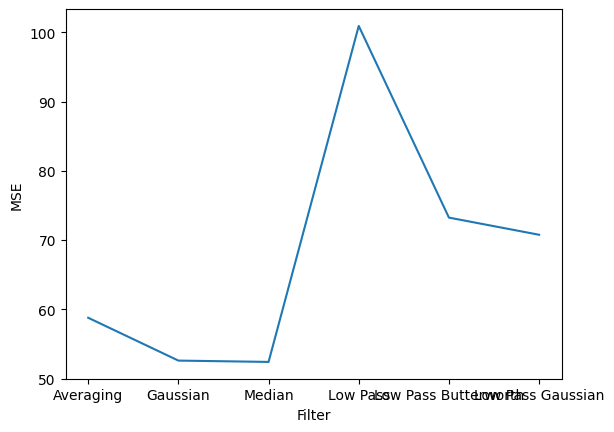

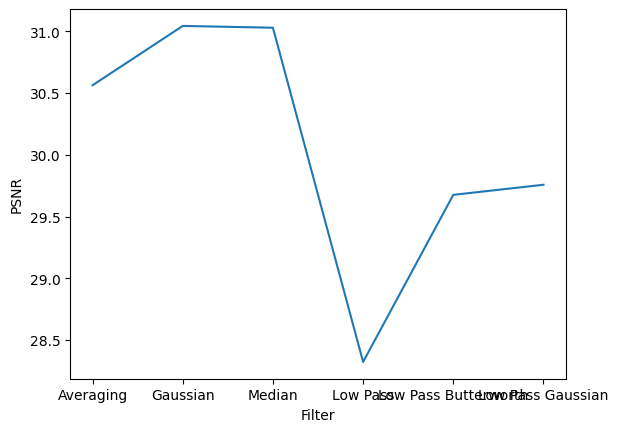

In [16]:
images = load_images()
images_noisy = []

kernel_size = 3
k0 = 12

for i in range((len(images))):
    img, img_noisy = add_noise(images[i], 0, 10)
    images_noisy.append(img_noisy)

images_avg = [averaging_filter(img, kernel_size) for img in images_noisy]
images_gaussian = [gaussian_filter(img, kernel_size) for img in images_noisy]
images_median = [median_filter(img, kernel_size) for img in images_noisy]

images_low_pass = [low_pass_filter(img, k0)[0] for img in images_noisy]
images_low_pass_butterworth = [low_pass_butterworth_filter(img, k0, 2)[0] for img in images_noisy]
images_low_pass_gaussian = [low_pass_gaussian_filter(img, k0)[0] for img in images_noisy]

mse_values = {
    'Averaging': [mse(img, img_filtered) for img, img_filtered in zip(images, images_avg)],
    'Gaussian': [mse(img, img_filtered) for img, img_filtered in zip(images, images_gaussian)],
    'Median': [mse(img, img_filtered) for img, img_filtered in zip(images, images_median)],
    'Low Pass': [mse(img, img_filtered) for img, img_filtered in zip(images, images_low_pass)],
    'Low Pass Butterworth': [mse(img, img_filtered) for img, img_filtered in zip(images, images_low_pass_butterworth)],
    'Low Pass Gaussian': [mse(img, img_filtered) for img, img_filtered in zip(images, images_low_pass_gaussian)]
}

psnr_values = {
    'Averaging': [psnr(img, img_filtered) for img, img_filtered in zip(images, images_avg)],
    'Gaussian': [psnr(img, img_filtered) for img, img_filtered in zip(images, images_gaussian)],
    'Median': [psnr(img, img_filtered) for img, img_filtered in zip(images, images_median)],
    'Low Pass': [psnr(img, img_filtered) for img, img_filtered in zip(images, images_low_pass)],
    'Low Pass Butterworth': [psnr(img, img_filtered) for img, img_filtered in zip(images, images_low_pass_butterworth)],
    'Low Pass Gaussian': [psnr(img, img_filtered) for img, img_filtered in zip(images, images_low_pass_gaussian)]
}

for filter_name in mse_values:
    print(f"{filter_name} filter")
    print(f"MSE: {np.mean(mse_values[filter_name])}")
    print(f"PSNR: {np.mean(psnr_values[filter_name])}")
    print()

plt.plot(list(mse_values.keys()), [np.mean(values) for values in mse_values.values()])
plt.xlabel('Filter')
plt.ylabel('MSE')
plt.show()

plt.plot(list(psnr_values.keys()), [np.mean(values) for values in psnr_values.values()])
plt.xlabel('Filter')
plt.ylabel('PSNR')
plt.show()

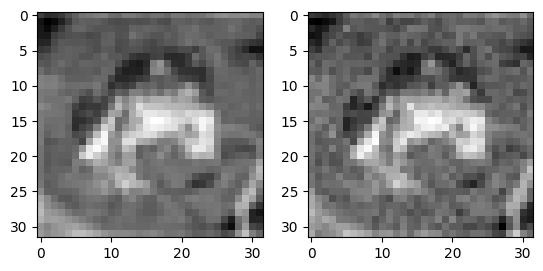

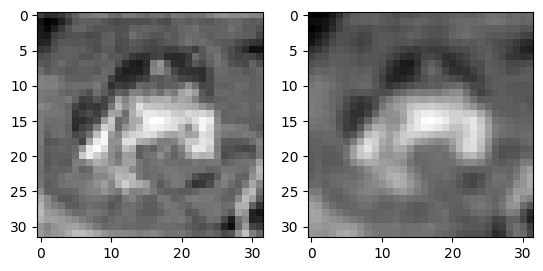

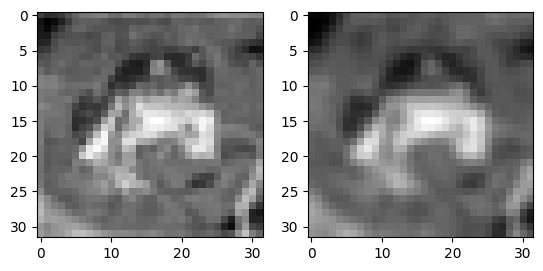

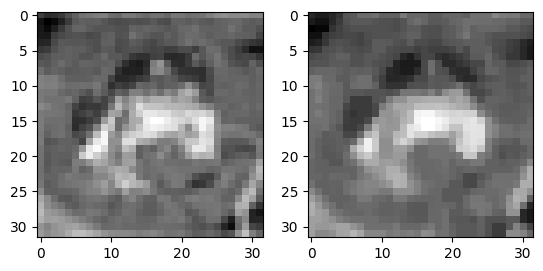

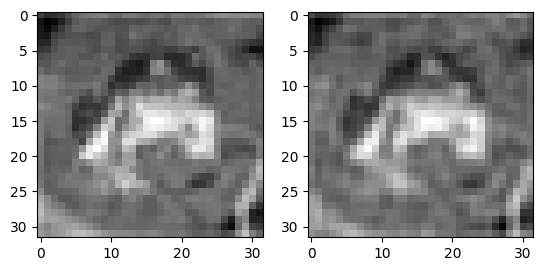

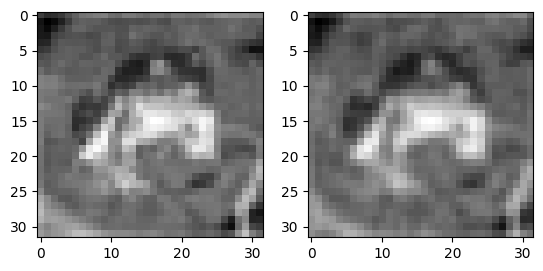

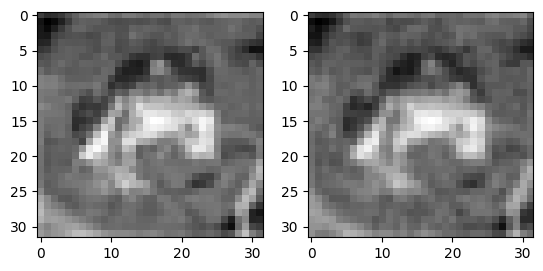

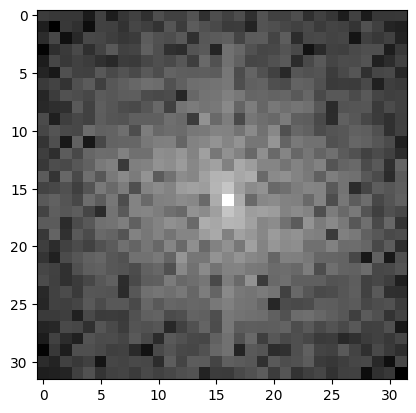

In [14]:
kernel_size = 3
k0 = 12

img = images[0]
img_noisy = images_noisy[0]

img_avg = averaging_filter(img_noisy, kernel_size)
img_gaussian = gaussian_filter(img_noisy, kernel_size)
img_median = median_filter(img_noisy, kernel_size)

img_low_pass, img_fft_shift = low_pass_filter(img_noisy, k0)
img_butterworth, img_fft_shift = low_pass_butterworth_filter(img_noisy, k0)
img_gaussian_low_pass, img_fft_shift = low_pass_gaussian_filter(img_noisy, k0)

plot_images(img, img_noisy)

plot_images(img, img_avg)
plot_images(img, img_gaussian)
plot_images(img, img_median)

plot_images(img, img_low_pass)
plot_images(img, img_butterworth)
plot_images(img, img_gaussian_low_pass)

plt.imshow(np.log(1 + np.abs(img_fft_shift)), cmap='gray')
plt.show()